In [1]:
from IPython.core.display import SVG

from copy import deepcopy

import networkx as nx
import pydot
import yaml

- [ ] 

In [2]:
hege_raw = None

with open("demo.yaml") as stream:
    try:
        hege_raw = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [3]:
hege_raw

{'entity-types': [{'name': 'person',
   'graphviz': {'shape': 'box'},
   'subtypes': [{'name': 'individual'},
    {'name': 'corporation', 'graphviz': {'style': 'rounded'}}]},
  {'name': 'institution', 'graphviz': {'shape': 'hexagon'}},
  {'name': 'information',
   'graphviz': {'shape': 'note'},
   'subtypes': [{'name': 'code'},
    {'name': 'standard'},
    {'name': 'model'},
    {'name': 'content'}]},
  {'name': 'machine', 'graphviz': {'shape': 'ellipse'}},
  {'name': 'service', 'graphviz': {'shape': 'ellipse'}},
  {'name': 'use case', 'graphviz': {'shape': 'plain'}}],
 'relation-types': [{'owns': {'subject': 'person'}},
  {'governs': {'subject': 'institution'}},
  {'implements': {'object': 'standard'}},
  {'creates': {'subject': 'person', 'object': 'information'}},
  {'operates': {'subject': 'corporaton', 'object': 'machine'}}],
 'entities': [{'name': 'Amazon', 'type': 'corporation'},
  {'name': 'Apple', 'type': 'corporation'},
  {'name': 'Cloudflare', 'type': 'corporation'},
  {'nam

In [4]:
def data_to_graph(raw):
    g = nx.DiGraph()
    
    for entity in raw['entities']:
        ent = deepcopy(entity)
        
        name = ent['name']
        del ent['name']
        
        g.add_node(name, **ent)
        
    for relation in raw['relations']:
        g.add_edge(
            relation['subject'],
            relation['object'],
            verb = relation['verb']
        )
            
    return g

In [5]:
def graphviz_lookup(typ, hraw):
    print(typ)
    # this can be optimized for constant time lookup with a preprocessing step
    for etyp in hraw['entity-types']:
        match = False
        if etyp['name'] == typ:
            match = True
            return etyp['graphviz']
        
        gv_attr = etyp['graphviz'].copy()
        
        if 'subtypes' in etyp:
            for estyp in etyp['subtypes']:
                if estyp['name'] == typ:
                    match = True

                    if 'graphviz' in estyp:
                        s_gv_attr = estyp['graphviz'].copy()
                        gv_attr.update(s_gv_attr)

        if match:
            return gv_attr

    return {}

In [6]:
graphviz_lookup('content', hege_raw)

content


{'shape': 'note'}

In [7]:
hege_graph = data_to_graph(hege_raw)

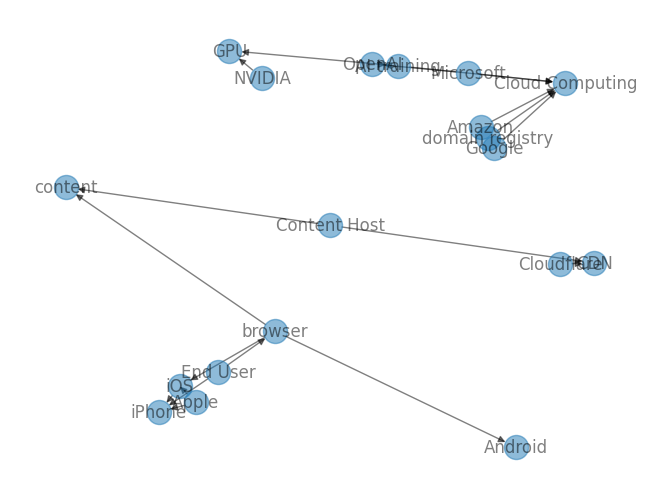

In [8]:
nx.draw(hege_graph, with_labels=True, alpha = 0.5)

In [9]:
def hege_graph_to_dot(hgraph, hraw):
    dot = pydot.Dot()
    
    # arbitrary, should be configurable
    dot.set('rankdir', 'TB')                                                    
    dot.set('concentrate', True)                                                
    dot.set_node_defaults(shape='record')
    
    for uid, dat in hgraph.nodes(data=True):
        node = pydot.Node(
                uid,
                #label = dat['long_name']
        )

        if 'type' in dat:
            gv_attr = graphviz_lookup(dat['type'], hraw)
        else:
            gv_attr = {}
        
        print(gv_attr)
        for attr in gv_attr:
            node.set(attr, gv_attr[attr])

        dot.add_node(node)
        
    for e in hgraph.edges(data=True):
        print(e)
        dot.add_edge(
            pydot.Edge(
                e[0],
                e[1],
                label = e[2]['verb']
            ))

    for n in dot.get_nodes():
        # Change the style of all nodes
        #n.set('style', 'filled')
        #n.set('fillcolor', 'aliceblue')
        n.set('fontsize', '10')
        n.set('fontname', 'Trebuchet MS, Tahoma, Verdana, Arial, Helvetica, sans-serif')

    return dot

In [10]:
hege_dot = hege_graph_to_dot(hege_graph, hege_raw)

corporation
{'shape': 'box', 'style': 'rounded'}
corporation
{'shape': 'box', 'style': 'rounded'}
corporation
{'shape': 'box', 'style': 'rounded'}
corporation
{'shape': 'box', 'style': 'rounded'}
corporation
{'shape': 'box', 'style': 'rounded'}
corporation
{'shape': 'box', 'style': 'rounded'}
corporation
{'shape': 'box', 'style': 'rounded'}
natural
{}
code
{'shape': 'note'}
code
{'shape': 'note'}
machine
{'shape': 'ellipse'}
service
{'shape': 'ellipse'}
service
{'shape': 'ellipse'}
corporation
{'shape': 'box', 'style': 'rounded'}
service
{'shape': 'ellipse'}
content
{'shape': 'note'}
service
{'shape': 'ellipse'}
machine
{'shape': 'ellipse'}
use case
{'shape': 'plain'}
('Amazon', 'Cloud Computing', {'verb': 'operates'})
('Apple', 'iPhone', {'verb': 'sells'})
('Apple', 'iOS', {'verb': 'sells'})
('Cloudflare', 'CDN', {'verb': 'operates'})
('Google', 'Cloud Computing', {'verb': 'operates'})
('Microsoft', 'Cloud Computing', {'verb': 'operates'})
('Microsoft', 'OpenAI', {'verb': 'invests in'

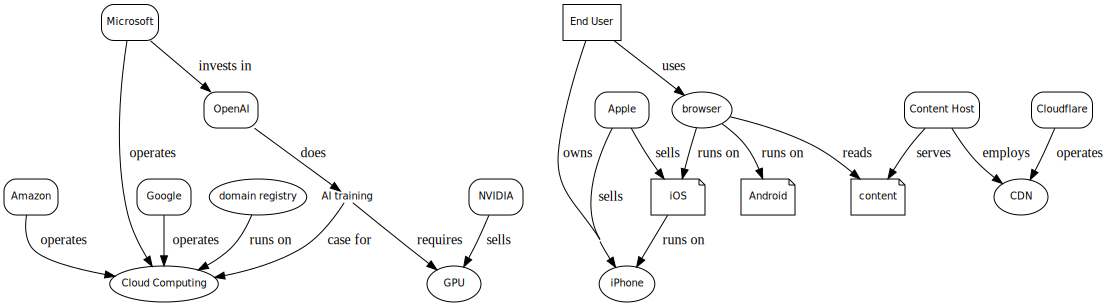

In [11]:
SVG(data = hege_dot.create_svg())

In [13]:
hege_dot.write_png('ietf121hackathon-demo.png')